In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier

%matplotlib inline

# Phase 1: Data Cleaning + EDA

In [3]:
df = pd.read_csv('train_data.csv')
df.head()

Customer Id  YearOfObservation  Insured_Period  Residential  \
0      H14663               2013             1.0            0   
1       H2037               2015             1.0            0   
2       H3802               2014             1.0            0   
3       H3834               2013             1.0            0   
4       H5053               2014             1.0            0   

  Building_Painted Building_Fenced Garden Settlement  Building Dimension  \
0                N               V      V          U               290.0   
1                V               N      O          R               490.0   
2                N               V      V          U               595.0   
3                V               V      V          U              2840.0   
4                V               N      O          R               680.0   

   Building_Type  Date_of_Occupancy NumberOfWindows Geo_Code  Claim  
0              1             1960.0               .     1053      0  
1              1             1850.0               4     1053      0  
2              1             1960.0               .     1053      0  
3              1             1960.0               .     1053      0  
4              1             1800.0               3     1053      0

In [4]:
df = df.drop('Customer Id', axis=1)

# replace . in NumberOfWindows with NaN
df['NumberOfWindows'] = df['NumberOfWindows'].replace('   .', np.nan)

In [5]:
rural_settlement = df.loc[df.Settlement == 'R']
rural_settlement.loc[rural_settlement.Garden == 'O']

YearOfObservation  Insured_Period  Residential Building_Painted  \
1                  2015        1.000000            0                V   
4                  2014        1.000000            0                V   
5                  2012        1.000000            0                V   
8                  2014        1.000000            0                V   
9                  2015        1.000000            0                V   
...                 ...             ...          ...              ...   
7049               2014        1.000000            0                V   
7050               2016        1.000000            0                V   
7051               2012        1.000000            0                V   
7052               2013        0.969863            0                V   
7053               2015        0.153425            0                V   

     Building_Fenced Garden Settlement  Building Dimension  Building_Type  \
1                  N      O          R               490.0              1   
4                  N      O          R               680.0              1   
5                  N      O          R               535.0              1   
8                  N      O          R              2735.0              1   
9                  N      O          R               520.0              1   
...              ...    ...        ...                 ...            ...   
7049               N      O          R              1850.0              3   
7050               N      O          R              1850.0              3   
7051               N      O          R              1775.0              3   
7052               N      O          R              1775.0              3   
7053               N      O          R              2444.0              3   

      Date_of_Occupancy NumberOfWindows Geo_Code  Claim  
1                1850.0               4     1053      0  
4                1800.0               3     1053      0  
5                1980.0               3     1143      0  
8                2013.0               3     1173      1  
9                2011.0               2     1224      0  
...                 ...             ...      ...    ...  
7049             2009.0               2    2B042      0  
7050             2009.0               2    2B042      0  
7051             2010.0               2    2B042      0  
7052             2010.0               2    2B042      0  
7053             1985.0               3    2B042      0  

[3602 rows x 13 columns]

In [6]:
df_profile = pandas_profiling.ProfileReport(df)
df_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def plot_feature_vs_target(feature):
    # YearOfObservation relation to number of claims
    # Group the data by year and claim
    grouped = df.groupby([feature, 'Claim']).size().reset_index(name='count')

    # Pivot the data to create separate columns for 0 and 1 claims
    pivoted = grouped.pivot(index=feature, columns='Claim', values='count')

    # Plot a stacked bar chart
    pivoted.plot(kind='bar', stacked=False)

    # Set the plot title and axis labels
    plt.title(f'Number of Claims by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')


    # Show the plot
    plt.show()

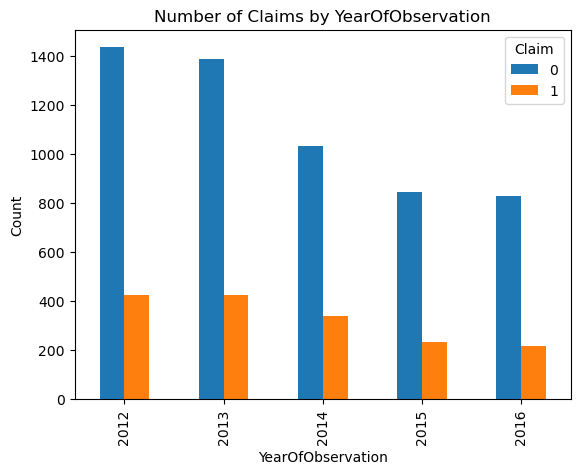

In [8]:
plot_feature_vs_target('YearOfObservation')

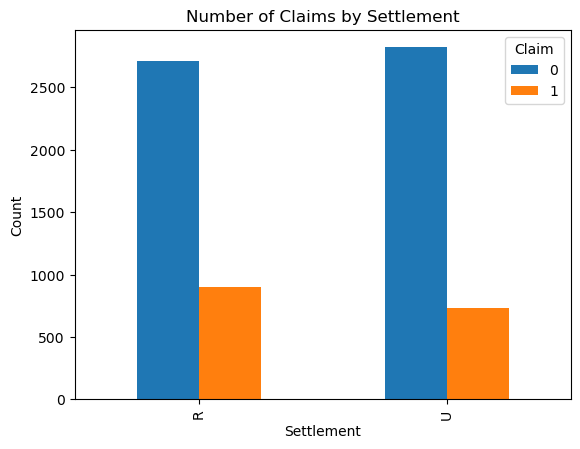

In [9]:
plot_feature_vs_target('Settlement')

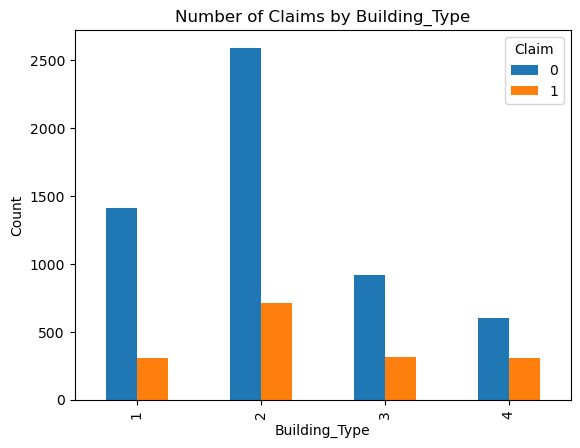

In [10]:
plot_feature_vs_target('Building_Type')

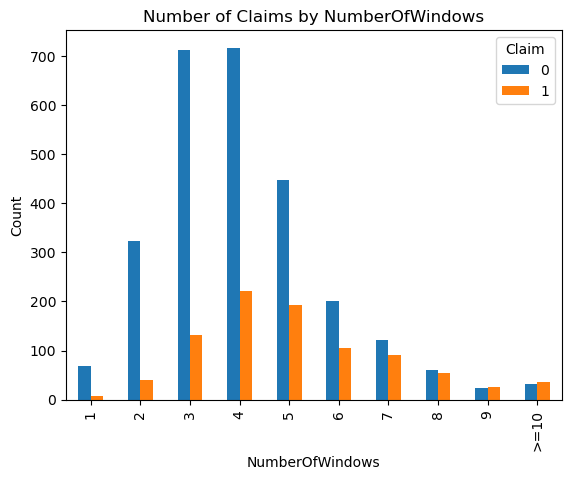

In [11]:
plot_feature_vs_target('NumberOfWindows')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   7160 non-null   int64  
 1   Insured_Period      7160 non-null   float64
 2   Residential         7160 non-null   int64  
 3   Building_Painted    7160 non-null   object 
 4   Building_Fenced     7160 non-null   object 
 5   Garden              7153 non-null   object 
 6   Settlement          7160 non-null   object 
 7   Building Dimension  7054 non-null   float64
 8   Building_Type       7160 non-null   int64  
 9   Date_of_Occupancy   6652 non-null   float64
 10  NumberOfWindows     3609 non-null   object 
 11  Geo_Code            7058 non-null   object 
 12  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 727.3+ KB


## Insights
1. All Urban settlements seem to have gardens
2. Only 1 instance of rural settlement has a garden
3. 99.6% of painted houses are in urban settlements
4. All instances where Settlement is Urban has the number of windows reporting an NaN
5. Target data is imbalanced

## NaN Values

### Number of windows

In [13]:
# Number of windows imputation
# highly correlated with Settlement & Garden
df.NumberOfWindows.unique()

array([nan, '4', '3', '2', '5', '>=10', '6', '7', '9', '8', '1'],
      dtype=object)

In [14]:
df.loc[(df.Settlement == 'U') & (df.NumberOfWindows.isna())]

YearOfObservation  Insured_Period  Residential Building_Painted  \
0                  2013        1.000000            0                N   
2                  2014        1.000000            0                N   
3                  2013        1.000000            0                V   
6                  2012        1.000000            0                N   
7                  2015        1.000000            0                N   
...                 ...             ...          ...              ...   
7155               2012        1.000000            1                V   
7156               2013        1.000000            0                V   
7157               2016        0.038251            0                V   
7158               2013        1.000000            0                V   
7159               2014        1.000000            0                V   

     Building_Fenced Garden Settlement  Building Dimension  Building_Type  \
0                  V      V          U               290.0              1   
2                  V      V          U               595.0              1   
3                  V      V          U              2840.0              1   
6                  V      V          U              2830.0              1   
7                  V      V          U              4952.0              1   
...              ...    ...        ...                 ...            ...   
7155               V      V          U                 NaN              1   
7156               V      V          U                 NaN              2   
7157               V      V          U                 NaN              1   
7158               V      V          U                 NaN              1   
7159               V      V          U                 NaN              1   

      Date_of_Occupancy NumberOfWindows Geo_Code  Claim  
0                1960.0             NaN     1053      0  
2                1960.0             NaN     1053      0  
3                1960.0             NaN     1053      0  
6                1988.0             NaN     1143      0  
7                1988.0             NaN     1160      0  
...                 ...             ...      ...    ...  
7155             2001.0             NaN      NaN      0  
7156             1980.0             NaN      NaN      1  
7157             1992.0             NaN      NaN      0  
7158             1972.0             NaN      NaN      0  
7159             2004.0             NaN      NaN      0  

[3550 rows x 13 columns]

In [15]:
df = df.drop('NumberOfWindows', axis=1)

### Garden

In [16]:
print(df.Garden.unique())
df.loc[df.Garden.isnull()]

['V' 'O' nan]


YearOfObservation  Insured_Period  Residential Building_Painted  \
2382               2015         0.99726            1                V   
3664               2012         1.00000            0                V   
3665               2013         1.00000            0                V   
4577               2013         1.00000            0                V   
4780               2013         1.00000            0                V   
4790               2012         1.00000            0                V   
4791               2014         1.00000            0                V   

     Building_Fenced Garden Settlement  Building Dimension  Building_Type  \
2382               N    NaN          R              8350.0              3   
3664               N    NaN          R              3900.0              1   
3665               N    NaN          R              3900.0              1   
4577               N    NaN          R               760.0              1   
4780               N    NaN          R              6203.0              1   
4790               N    NaN          R               350.0              1   
4791               N    NaN          R               350.0              1   

      Date_of_Occupancy Geo_Code  Claim  
2382             1985.0    33069      1  
3664             1976.0    61483      0  
3665             1976.0    61483      1  
4577             1969.0    73015      0  
4780             1990.0    74173      0  
4790             1960.0    74173      0  
4791             1960.0    74173      0

In [17]:
df.loc[df.Settlement == 'U', 'Garden'] = 'V'
df.loc[df.Settlement != 'U', 'Garden'] = 'O'
df.head()

YearOfObservation  Insured_Period  Residential Building_Painted  \
0               2013             1.0            0                N   
1               2015             1.0            0                V   
2               2014             1.0            0                N   
3               2013             1.0            0                V   
4               2014             1.0            0                V   

  Building_Fenced Garden Settlement  Building Dimension  Building_Type  \
0               V      V          U               290.0              1   
1               N      O          R               490.0              1   
2               V      V          U               595.0              1   
3               V      V          U              2840.0              1   
4               N      O          R               680.0              1   

   Date_of_Occupancy Geo_Code  Claim  
0             1960.0     1053      0  
1             1850.0     1053      0  
2             1960.0     1053      0  
3             1960.0     1053      0  
4             1800.0     1053      0

### Building Dimension

- The assumption made here is that rural buildings differ from Urban buildings in size on a generic scale


In [18]:
df.groupby('Settlement')['Building Dimension'].mean().reset_index()

Settlement  Building Dimension
0          R         2178.223885
1          U         1575.211611

In [19]:
rural_dim = df[df['Settlement'] == 'R']
rural_dim_mean = rural_dim["Building Dimension"].mean()
urban_dim = df[df['Settlement'] == 'U']
urban_dim_mean = urban_dim["Building Dimension"].mean()

- Replace NaN of Building Settlement with mean of rural_dim_mean if its Settlement type is Rural 'R'.  
- Replace NaN of Building Settlement with mean of urban_dim_mean if its Settlement type is Urban 'U'

In [20]:
for i in range(len(df.Settlement)):
    if (df.Settlement[i] == 'U') and pd.isnull(df['Building Dimension'][i]):
        df.at[i, 'Building Dimension'] = urban_dim_mean
    elif (df.Settlement[i] == 'R') and pd.isnull(df['Building Dimension'][i]):
        df.at[i, 'Building Dimension'] = rural_dim_mean

### Date of Occupancy

In [21]:
#replace NaN values with mode date
date_mode = df.Date_of_Occupancy.mode()[0]
df.Date_of_Occupancy.fillna(date_mode, inplace=True)

df['Date_of_Occupancy'] = df['Date_of_Occupancy'].astype(int)

### Geo Code

In [22]:
df.groupby('Settlement')['Geo_Code'].apply(lambda x: x.mode()[0])

Settlement
R    33063
U     6088
Name: Geo_Code, dtype: object

In [23]:
rural_dim = df[df['Settlement'] == 'R']
rural_dim_mean = rural_dim["Geo_Code"].mode()[0]
urban_dim = df[df['Settlement'] == 'U']
urban_dim_mean = urban_dim["Geo_Code"].mode()[0]

for i in range(len(df.Settlement)):
    if (df.Settlement[i] == 'U') and pd.isnull(df['Geo_Code'][i]):
        df.at[i, 'Geo_Code'] = urban_dim_mean
    elif (df.Settlement[i] == 'R') and pd.isnull(df['Geo_Code'][i]):
        df.at[i, 'Geo_Code'] = rural_dim_mean

- Geo code has high cardinality  
- One possible way to resolve this would be to engineer the locations/state of the codes into a diff col 
- For now Geo_Code is being dropped


In [24]:
# drop Geo_Code
df = df.drop('Geo_Code', axis=1)

In [25]:
df_profile = pandas_profiling.ProfileReport(df)
df_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
# save df to train_clean.csv
df.to_csv('train_clean.csv', index=False)

# Phase 2: Feature Extraction & Engineering

In [27]:
# Convert the numerical values to string labels for building type
mapping = {1: 'type1', 2: 'type2', 3: 'type3', 4: 'type4'}
df['Building_Type'] = df['Building_Type'].map(mapping)
df.head()

YearOfObservation  Insured_Period  Residential Building_Painted  \
0               2013             1.0            0                N   
1               2015             1.0            0                V   
2               2014             1.0            0                N   
3               2013             1.0            0                V   
4               2014             1.0            0                V   

  Building_Fenced Garden Settlement  Building Dimension Building_Type  \
0               V      V          U               290.0         type1   
1               N      O          R               490.0         type1   
2               V      V          U               595.0         type1   
3               V      V          U              2840.0         type1   
4               N      O          R               680.0         type1   

   Date_of_Occupancy  Claim  
0               1960      0  
1               1850      0  
2               1960      0  
3               1960      0  
4               1800      0

### Train Test Split


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Claim', axis=1), df['Claim'], test_size=0.2, random_state=42)  
X_train

YearOfObservation  Insured_Period  Residential Building_Painted  \
5266               2016        0.997268            1                N   
5441               2015        1.000000            0                N   
7025               2013        1.000000            0                V   
7130               2014        1.000000            1                V   
4454               2013        1.000000            0                V   
...                 ...             ...          ...              ...   
3772               2015        1.000000            0                V   
5191               2013        1.000000            1                V   
5226               2014        1.000000            1                V   
5390               2012        1.000000            1                N   
860                2012        1.000000            1                V   

     Building_Fenced Garden Settlement  Building Dimension Building_Type  \
5266               V      V          U          850.000000         type4   
5441               V      V          U         2135.000000         type2   
7025               N      O          R         2700.000000         type3   
7130               V      V          U         1575.211611         type1   
4454               N      O          R         1080.000000         type2   
...              ...    ...        ...                 ...           ...   
3772               N      O          R          750.000000         type2   
5191               N      O          R         2670.000000         type4   
5226               N      O          R         2200.000000         type4   
5390               V      V          U          634.000000         type2   
860                N      O          R          250.000000         type1   

      Date_of_Occupancy  
5266               1960  
5441               1960  
7025               1970  
7130               1700  
4454               1960  
...                 ...  
3772               1990  
5191               1950  
5226               1904  
5390               1960  
860                1950  

[5728 rows x 10 columns]

### Encode Categorical Cols

In [29]:
cols_to_encode = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type']

# Perform one-hot encoding on cols
X_train = pd.get_dummies(X_train, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)
X_train

YearOfObservation  Insured_Period  Residential  Building Dimension  \
5266               2016        0.997268            1          850.000000   
5441               2015        1.000000            0         2135.000000   
7025               2013        1.000000            0         2700.000000   
7130               2014        1.000000            1         1575.211611   
4454               2013        1.000000            0         1080.000000   
...                 ...             ...          ...                 ...   
3772               2015        1.000000            0          750.000000   
5191               2013        1.000000            1         2670.000000   
5226               2014        1.000000            1         2200.000000   
5390               2012        1.000000            1          634.000000   
860                2012        1.000000            1          250.000000   

      Date_of_Occupancy  Building_Painted_N  Building_Painted_V  \
5266               1960                   1                   0   
5441               1960                   1                   0   
7025               1970                   0                   1   
7130               1700                   0                   1   
4454               1960                   0                   1   
...                 ...                 ...                 ...   
3772               1990                   0                   1   
5191               1950                   0                   1   
5226               1904                   0                   1   
5390               1960                   1                   0   
860                1950                   0                   1   

      Building_Fenced_N  Building_Fenced_V  Garden_O  Garden_V  Settlement_R  \
5266                  0                  1         0         1             0   
5441                  0                  1         0         1             0   
7025                  1                  0         1         0             1   
7130                  0                  1         0         1             0   
4454                  1                  0         1         0             1   
...                 ...                ...       ...       ...           ...   
3772                  1                  0         1         0             1   
5191                  1                  0         1         0             1   
5226                  1                  0         1         0             1   
5390                  0                  1         0         1             0   
860                   1                  0         1         0             1   

      Settlement_U  Building_Type_type1  Building_Type_type2  \
5266             1                    0                    0   
5441             1                    0                    1   
7025             0                    0                    0   
7130             1                    1                    0   
4454             0                    0                    1   
...            ...                  ...                  ...   
3772             0                    0                    1   
5191             0                    0                    0   
5226             0                    0                    0   
5390             1                    0                    1   
860              0                    1                    0   

      Building_Type_type3  Building_Type_type4  
5266                    0                    1  
5441                    0                    0  
7025                    1                    0  
7130                    0                    0  
4454                    0                    0  
...                   ...                  ...  
3772                    0                    0  
5191                    0                    1  
5226                    0                    1  
5390                    0                    0  
860                

### Baseline Model

In [30]:
def analyze_results(final_model, X_test, y_pred):
    # Predict the probabilities of the test set
    y_prob = final_model.predict_proba(X_test)[:, 1]

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    
    # Add the number of values in each cell of the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment='center',
                     verticalalignment='center')
            
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.show()

    # Compute the ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    # identify optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print("Optimal threshold:", optimal_threshold)

In [41]:
def train_random_forest_model(X_train, y_train, X_test):
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]}

    # Create a RandomForestClassifier
    rfc = RandomForestClassifier(random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rfc, 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Use the best hyperparameters to create a final model
    final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

    # Fit the final model to the data
    final_model.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = final_model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the roc_score report   
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(final_model, X_test, y_pred)

In [32]:
def train_xgboost_model(X_train, y_train, X_test):
    # Define the XGBoost model
    xgb_model = XGBClassifier()

    # Define the parameter grid to search over
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=params, 
        scoring='roc_auc', 
        cv=5, 
#         refit='roc_auc', 
        n_jobs=-1
    )

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train an XGBoost model with the best parameters
    xgb_model_best = XGBClassifier(**best_params)
    xgb_model_best.fit(X_train, y_train)

    # Predict the test set
    y_pred = xgb_model_best.predict(X_test)
    
    # Print the best parameters and best score
    print('Best parameters: ', best_params)
    print('Best score: ', best_score)
    
    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Print the roc_score report   
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(xgb_model_best, X_test, y_pred)

In [33]:
def train_gradient_boosting_model(X_train, y_train, X_test):
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]}

    # Create a GradientBoostingClassifier
    gbc = GradientBoostingClassifier(random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=gbc, 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Use the best hyperparameters to create a final model
    final_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)

    # Fit the final model to the data
    final_model.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = final_model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the roc_score report    
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(final_model, X_test, y_pred)

In [34]:
def train_stacking_model(X_train, y_train, X_test):
    # Define the base models
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('gbc', GradientBoostingClassifier(random_state=42))
    ]

    # Define the meta model
    meta_model = LogisticRegression(random_state=42)

    # Fit the stacked model with the best number of estimators
    stacked_model = StackingClassifier(estimators=base_models, 
                                       final_estimator=meta_model)
    stacked_model.fit(X_train, y_train)

    # Make predictions on the test set and evaluate the model
    y_pred = stacked_model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Print the roc_score report    
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(stacked_model, X_test, y_pred)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.7129984450768778
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1098
           1       0.60      0.17      0.27       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.5690667844638592


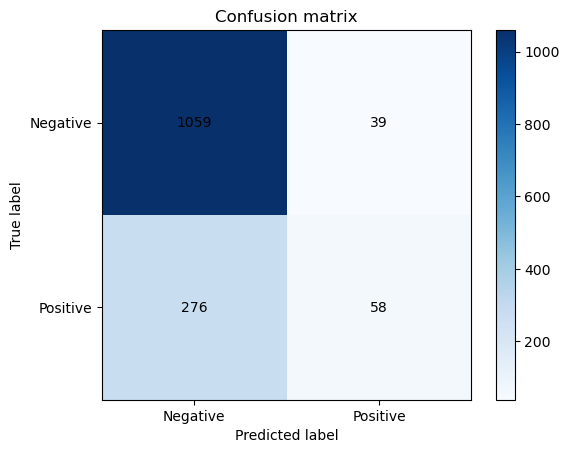

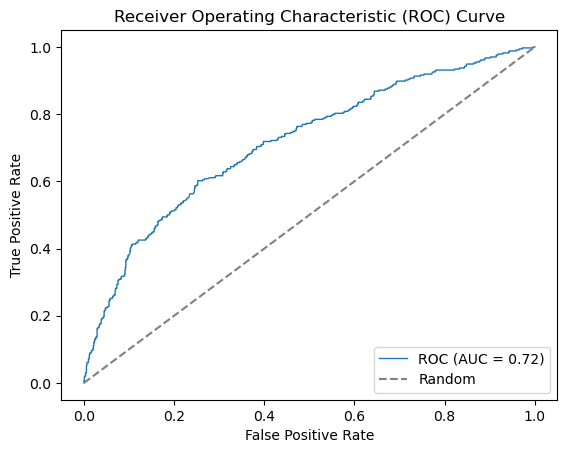

In [60]:
train_random_forest_model(X_train, y_train, X_test)

### Create Building Occupancy Period [Years] Col

- Occupancy period represents how long people have been staying in a building from the first recorded occupancy to the year in which the insurance policy was created  

- Subtract Date_of_occupancy from YearOfObservation for new col   

- The assumption made here is that each insurance made here is for a unique house and the YearOfObservation was the very first time the building was insured

In [35]:
X_train['Occupancy_Period'] = X_train['YearOfObservation'] - X_train['Date_of_Occupancy']
X_test['Occupancy_Period'] = X_test['YearOfObservation'] - X_test['Date_of_Occupancy']
X_train = X_train.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)
X_test = X_test.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)
X_train

Insured_Period  Residential  Building Dimension  Building_Painted_N  \
5266        0.997268            1          850.000000                   1   
5441        1.000000            0         2135.000000                   1   
7025        1.000000            0         2700.000000                   0   
7130        1.000000            1         1575.211611                   0   
4454        1.000000            0         1080.000000                   0   
...              ...          ...                 ...                 ...   
3772        1.000000            0          750.000000                   0   
5191        1.000000            1         2670.000000                   0   
5226        1.000000            1         2200.000000                   0   
5390        1.000000            1          634.000000                   1   
860         1.000000            1          250.000000                   0   

      Building_Painted_V  Building_Fenced_N  Building_Fenced_V  Garden_O  \
5266                   0                  0                  1         0   
5441                   0                  0                  1         0   
7025                   1                  1                  0         1   
7130                   1                  0                  1         0   
4454                   1                  1                  0         1   
...                  ...                ...                ...       ...   
3772                   1                  1                  0         1   
5191                   1                  1                  0         1   
5226                   1                  1                  0         1   
5390                   0                  0                  1         0   
860                    1                  1                  0         1   

      Garden_V  Settlement_R  Settlement_U  Building_Type_type1  \
5266         1             0             1                    0   
5441         1             0             1                    0   
7025         0             1             0                    0   
7130         1             0             1                    1   
4454         0             1             0                    0   
...        ...           ...           ...                  ...   
3772         0             1             0                    0   
5191         0             1             0                    0   
5226         0             1             0                    0   
5390         1             0             1                    0   
860          0             1             0                    1   

      Building_Type_type2  Building_Type_type3  Building_Type_type4  \
5266                    0                    0                    1   
5441                    1                    0                    0   
7025                    0                    1                    0   
7130                    0                    0                    0   
4454                    1                    0                    0   
...                   ...                  ...                  ...   
3772                    1                    0                    0   
5191                    0                    0                    1   
5226                    0                    0                    1   
5390                    1                    0                    0   
860                     0                    0                    0   

      Occupancy_Period  
5266                56  
5441                55  
7025                43  
7130               314  
4454                53  
...                ...  
3772                25  
5191                63  
5226               110  
5390                52  
860                 62  

[5728 rows x 16 columns]

### Scale numerical features

In [36]:
# instantiate the scaler
scaler = StandardScaler()

# define columns to scale
cols_to_scale = ['Insured_Period', 'Building Dimension', 'Occupancy_Period']

# fit and transform the training set
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# transform the test set using the fitted scaler from the training set
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_train

Insured_Period  Residential  Building Dimension  Building_Painted_N  \
5266        0.361737            1           -0.452685                   1   
5441        0.373259            0            0.115754                   1   
7025        0.373259            0            0.365690                   0   
7130        0.373259            1           -0.131877                   0   
4454        0.373259            0           -0.350941                   0   
...              ...          ...                 ...                 ...   
3772        0.373259            0           -0.496922                   0   
5191        0.373259            1            0.352419                   0   
5226        0.373259            1            0.144508                   0   
5390        0.373259            1           -0.548236                   1   
860         0.373259            1           -0.718104                   0   

      Building_Painted_V  Building_Fenced_N  Building_Fenced_V  Garden_O  \
5266                   0                  0                  1         0   
5441                   0                  0                  1         0   
7025                   1                  1                  0         1   
7130                   1                  0                  1         0   
4454                   1                  1                  0         1   
...                  ...                ...                ...       ...   
3772                   1                  1                  0         1   
5191                   1                  1                  0         1   
5226                   1                  1                  0         1   
5390                   0                  0                  1         0   
860                    1                  1                  0         1   

      Garden_V  Settlement_R  Settlement_U  Building_Type_type1  \
5266         1             0             1                    0   
5441         1             0             1                    0   
7025         0             1             0                    0   
7130         1             0             1                    1   
4454         0             1             0                    0   
...        ...           ...           ...                  ...   
3772         0             1             0                    0   
5191         0             1             0                    0   
5226         0             1             0                    0   
5390         1             0             1                    0   
860          0             1             0                    1   

      Building_Type_type2  Building_Type_type3  Building_Type_type4  \
5266                    0                    0                    1   
5441                    1                    0                    0   
7025                    0                    1                    0   
7130                    0                    0                    0   
4454                    1                    0                    0   
...                   ...                  ...                  ...   
3772                    1                    0                    0   
5191                    0                    0                    1   
5226                    0                    0                    1   
5390                    1                    0                    0   
860                     0                    0                    0   

      Occupancy_Period  
5266          0.182678  
5441          0.154069  
7025         -0.189241  
7130          7.563840  
4454          0.096851  
...                ...  
3772         -0.704206  
5191          0.382942  
5226          1.727572  
5390          0.068241  
860           0.354333  

[5728 rows x 16 columns]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.7129984450768778
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1098
           1       0.60      0.17      0.27       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.5690667844638592


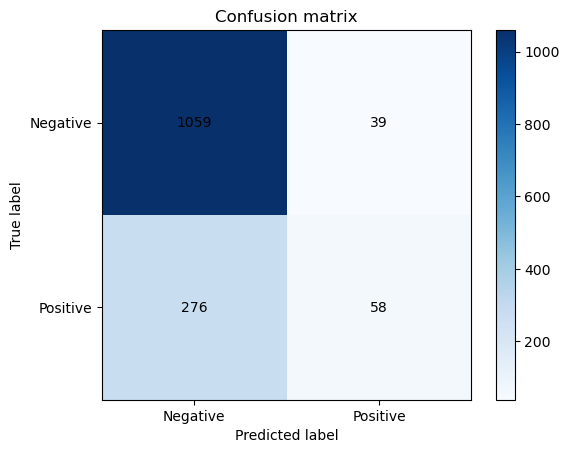

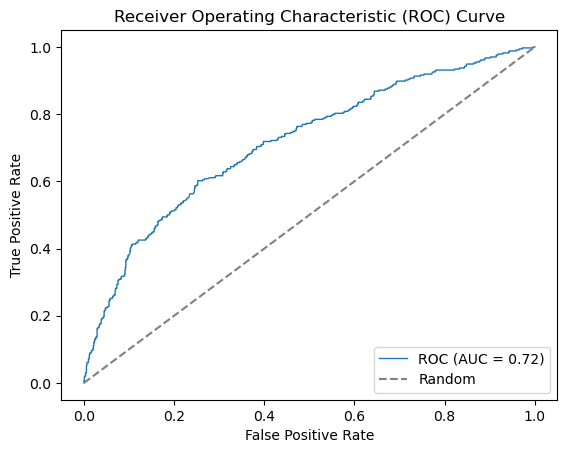

In [71]:
train_random_forest_model(X_train, y_train)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.7188784535725462
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.62      0.18      0.28       334

    accuracy                           0.78      1432
   macro avg       0.71      0.57      0.58      1432
weighted avg       0.76      0.78      0.73      1432

ROC_AUC_SCORE: 0.5734269166584863


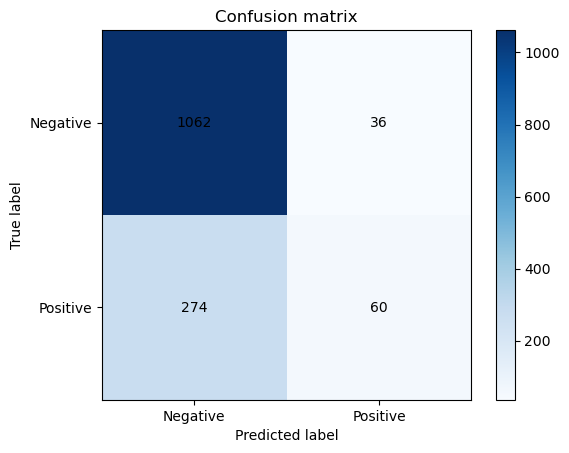

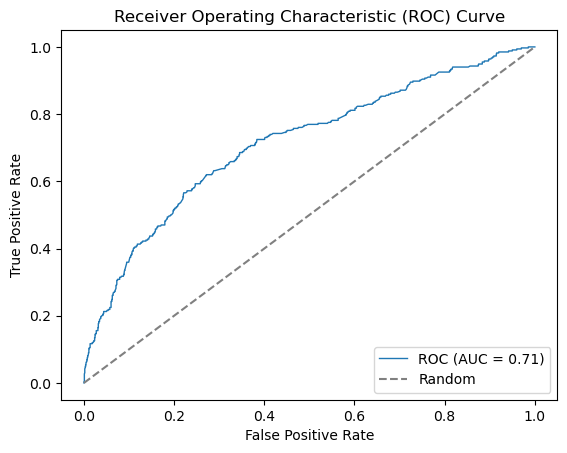

In [74]:
train_xgboost_model(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  0.7205285379896659
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1098
           1       0.59      0.21      0.31       334

    accuracy                           0.78      1432
   macro avg       0.70      0.58      0.59      1432
weighted avg       0.75      0.78      0.74      1432

ROC_AUC_SCORE: 0.5818908630825781


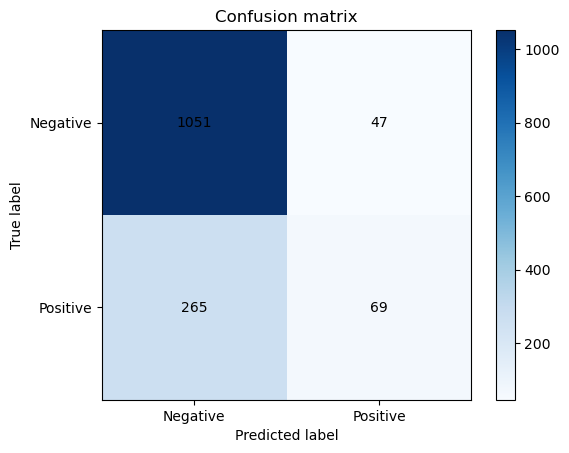

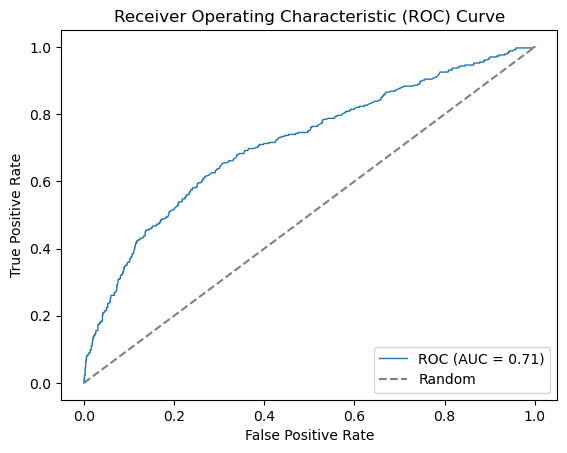

In [75]:
train_gradient_boosting_model(X_train, y_train)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1098
           1       0.57      0.17      0.26       334

    accuracy                           0.78      1432
   macro avg       0.68      0.57      0.57      1432
weighted avg       0.74      0.78      0.73      1432

ROC_AUC_SCORE: 0.5657482848510629


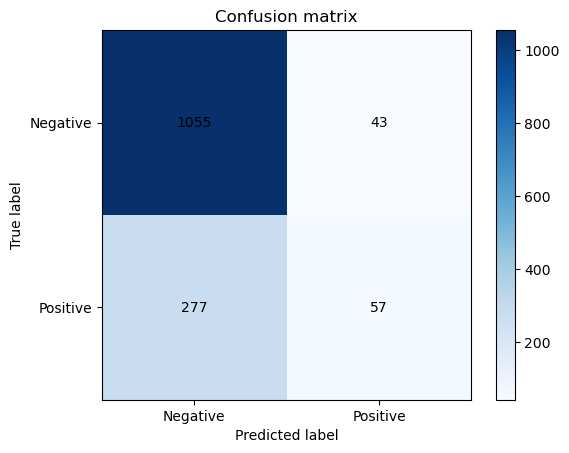

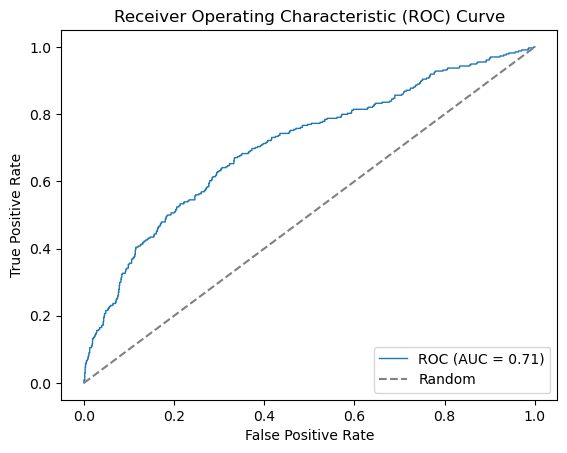

In [76]:
train_stacking_model(X_train, y_train)

### Fixing Data Imbalance

#### Smote

In [37]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

# Fit and transform the data
X_train_sm_resampled, y_train_sm_resampled = sm.fit_resample(X_train, y_train)

In [38]:
y_train_sm_resampled.value_counts()

0    4428
1    4428
Name: Claim, dtype: int64

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.8689510328355194
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1098
           1       0.39      0.39      0.39       334

    accuracy                           0.71      1432
   macro avg       0.60      0.60      0.60      1432
weighted avg       0.72      0.71      0.71      1432

ROC_AUC_SCORE: 0.6023008627553635


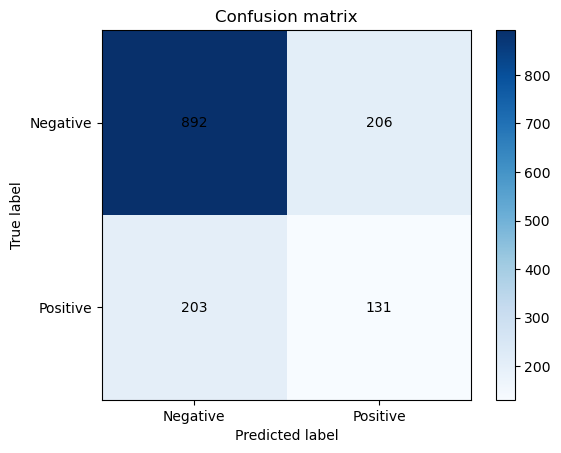

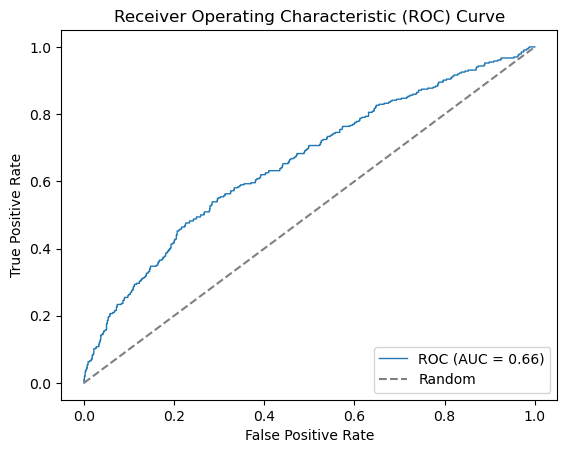

In [79]:
train_random_forest_model(X_train_sm_resampled, y_train_sm_resampled)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best score:  0.8810171817637533
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1098
           1       0.46      0.37      0.41       334

    accuracy                           0.75      1432
   macro avg       0.64      0.62      0.62      1432
weighted avg       0.73      0.75      0.74      1432

ROC_AUC_SCORE: 0.6170609600471189


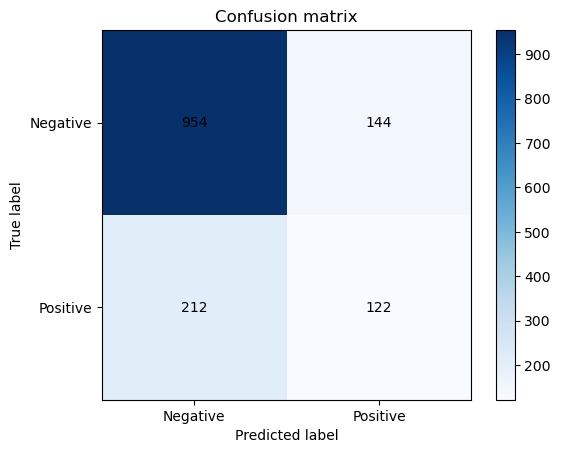

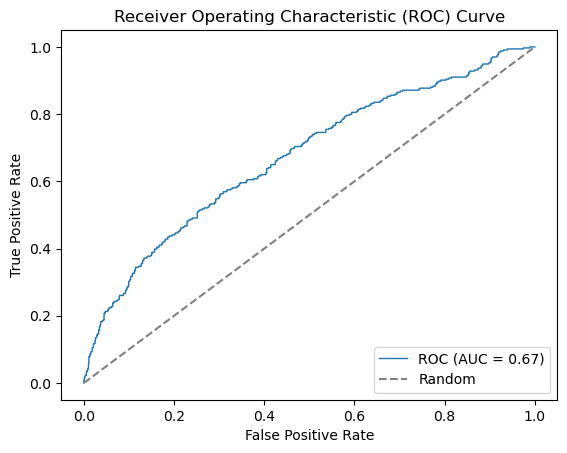

In [80]:
train_xgboost_model(X_train_sm_resampled, y_train_sm_resampled)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.8859544602235261
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1098
           1       0.43      0.35      0.39       334

    accuracy                           0.74      1432
   macro avg       0.62      0.61      0.61      1432
weighted avg       0.72      0.74      0.73      1432

ROC_AUC_SCORE: 0.6056084552207063


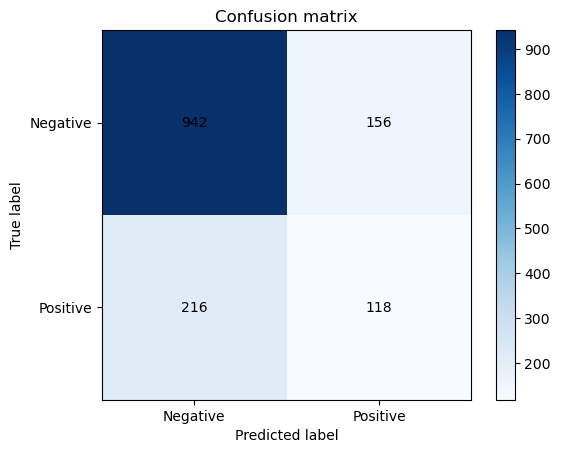

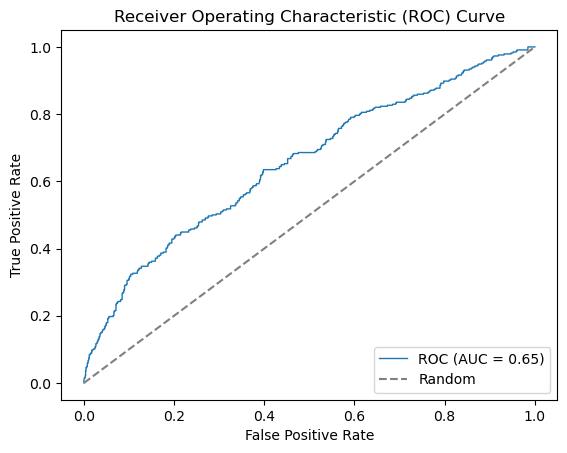

In [81]:
train_gradient_boosting_model(X_train_sm_resampled, y_train_sm_resampled)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1098
           1       0.39      0.37      0.38       334

    accuracy                           0.72      1432
   macro avg       0.60      0.60      0.60      1432
weighted avg       0.71      0.72      0.72      1432

ROC_AUC_SCORE: 0.5991077953382852


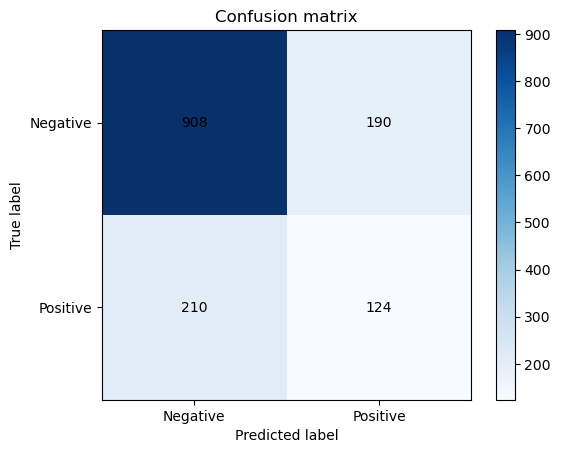

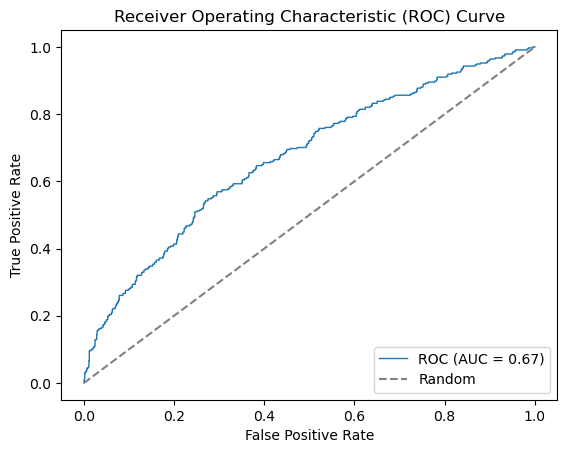

In [82]:
train_stacking_model(X_train_sm_resampled, y_train_sm_resampled)

#### Class Weight Balancing

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.7152280385503211
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1098
           1       0.68      0.06      0.10       334

    accuracy                           0.77      1432
   macro avg       0.73      0.52      0.49      1432
weighted avg       0.75      0.77      0.69      1432

ROC_AUC_SCORE: 0.5243447531167175


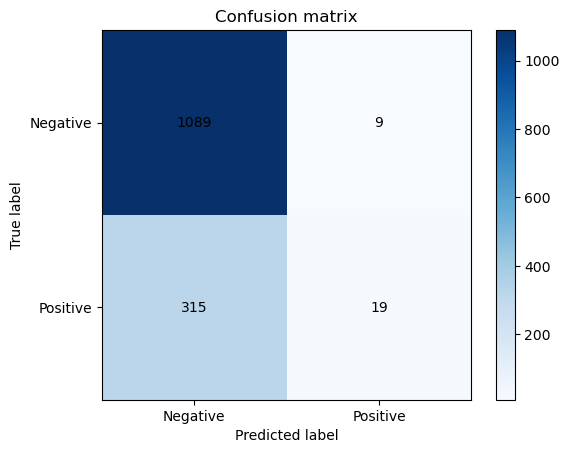

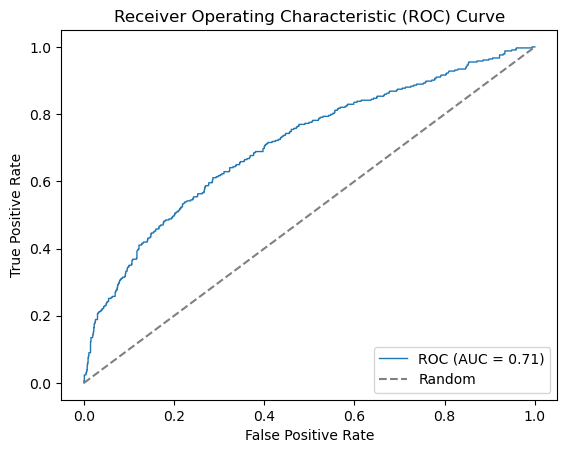

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

In [85]:
# Get unique class labels in target variable
classes = np.unique(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Create a dictionary with class weights
class_weights_dict = dict(enumerate(class_weights))

# Define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]}

# Create a RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best hyperparameters to create a final model
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Fit the final model to the data
final_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = final_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the roc_score report    
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
analyze_results(final_model, X_test, y_pred)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.7188784535725462
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.62      0.18      0.28       334

    accuracy                           0.78      1432
   macro avg       0.71      0.57      0.58      1432
weighted avg       0.76      0.78      0.73      1432

ROC_AUC_SCORE: 0.5734269166584863


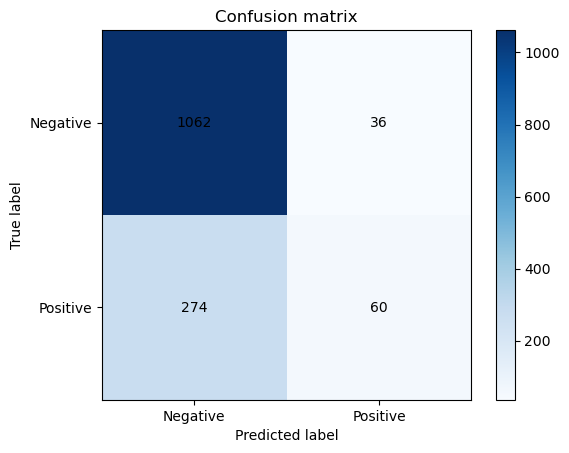

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

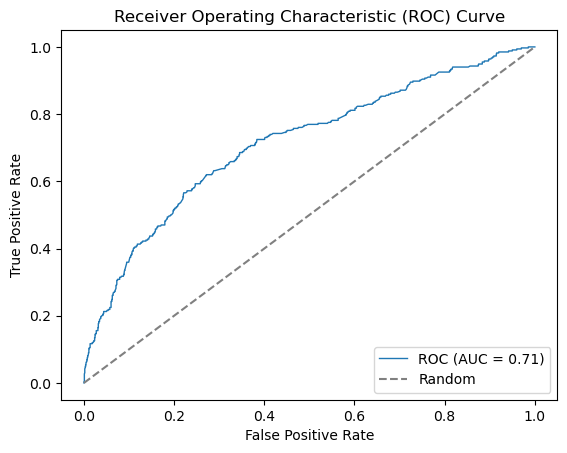

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\yeboa\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\yeboa\anaconda3\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed b

In [86]:
# Get unique class labels in target variable
classes = np.unique(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Set the positive class weight
scale_pos_weight = class_weights[1] / class_weights[0]

# Define the parameter grid to search over
# param_grid = {'n_estimators': [50, 100, 200],
#             'max_depth': [3, 5, 10, None],
#             'learning_rate': [0.01, 0.1, 0.5],
#             'subsample': [0.5, 0.7, 1],
#             'colsample_bytree': [0.5, 0.7, 1],
#             'reg_alpha': [0, 0.1, 0.5],
#             'reg_lambda': [1, 1.5, 2],
#             'scale_pos_weight': [scale_pos_weight]}
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Create an XGBClassifier
xgb_model = XGBClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best hyperparameters to create a final model
final_model = XGBClassifier(**grid_search.best_params_, random_state=42)

# Fit the final model to the data
final_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = final_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the roc_score report    
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')

analyze_results(final_model, X_test, y_pred)

### Utilizing LASSO for feature Extraction

In [39]:
# perform LassoCV to find the optimal alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# extract the coefficients of the non-zero features
coef = pd.Series(lasso.coef_, index=X_train.columns)
selected_features = coef[coef != 0].index.tolist()
selected_features

['Insured_Period',
 'Residential',
 'Building Dimension',
 'Building_Painted_N',
 'Building_Painted_V',
 'Building_Type_type1',
 'Building_Type_type2',
 'Building_Type_type4',
 'Occupancy_Period']

In [40]:
X_train_lasso, X_test_lasso = X_train[selected_features], X_test[selected_features]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.7155103910067565
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      1098
           1       0.66      0.13      0.22       334

    accuracy                           0.78      1432
   macro avg       0.72      0.56      0.55      1432
weighted avg       0.76      0.78      0.72      1432

ROC_AUC_SCORE: 0.555394675130613


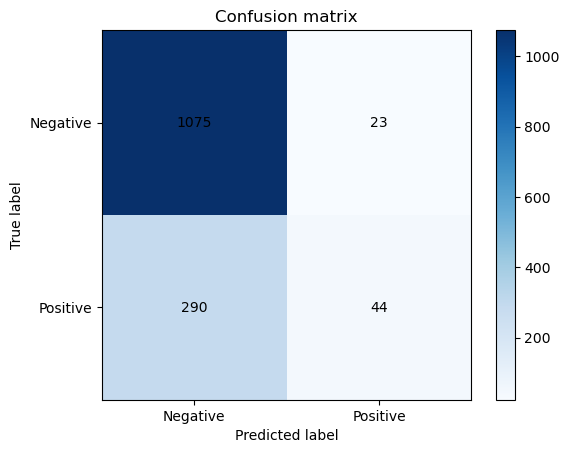

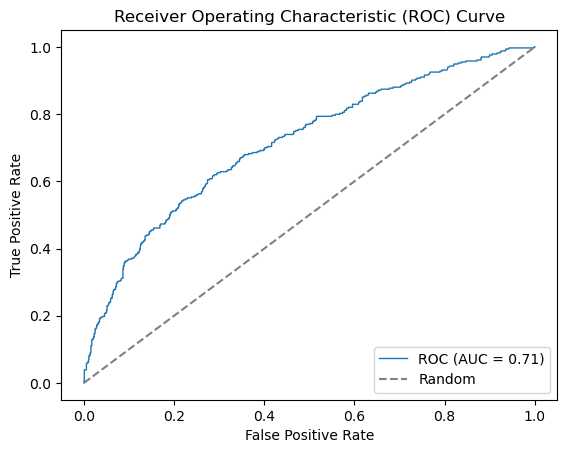

In [42]:
train_random_forest_model(X_train_lasso, y_train, X_test_lasso)

#### Tree Based Method for Feature Extraction

In [47]:
# Initialize the random forest classifier with default parameters
rfc = RandomForestClassifier()

# Fit the random forest classifier on the training data
rfc.fit(X_train, y_train)

# Get feature importances
importances = rfc.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Building Dimension (0.551884)
2. Occupancy_Period (0.288164)
3. Insured_Period (0.083457)
4. Residential (0.020065)
5. Building_Type_type4 (0.011680)
6. Building_Type_type1 (0.009004)
7. Building_Type_type2 (0.008679)
8. Building_Type_type3 (0.007361)
9. Building_Painted_N (0.005581)
10. Building_Painted_V (0.005559)
11. Building_Fenced_N (0.001655)
12. Settlement_R (0.001555)
13. Garden_O (0.001430)
14. Garden_V (0.001374)
15. Building_Fenced_V (0.001276)
16. Settlement_U (0.001275)


#### Mutual Information

In [63]:
# Calculate mutual information scores for each feature
mi_scores = mutual_info_classif(X_train, y_train)

# Create a dictionary with feature names and their corresponding scores
mi_scores_dict = dict(zip(X_train.columns, mi_scores))

# Sort the features by their scores in descending order
sorted_features = sorted(mi_scores_dict.items(), key=lambda x: x[1], reverse=True)

# Print the features and their corresponding scores
for feature, score in sorted_features:
    print(f"{feature}: {score:.2f}")

Building Dimension: 0.06
Residential: 0.01
Settlement_R: 0.01
Garden_V: 0.01
Building_Type_type1: 0.01
Occupancy_Period: 0.00
Building_Fenced_N: 0.00
Building_Painted_V: 0.00
Building_Type_type4: 0.00
Garden_O: 0.00
Insured_Period: 0.00
Building_Type_type2: 0.00
Building_Painted_N: 0.00
Building_Fenced_V: 0.00
Settlement_U: 0.00
Building_Type_type3: 0.00
